<a href="https://colab.research.google.com/github/sberdine77/LSTM-aws-spot-price/blob/main/notebook/LSTM_aws_spot_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# Necessary instalations
import sys
## Uncomment for MacOS
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install tensorflow-macos==2.9
#!{sys.executable} -m pip install tensorflow-metal==0.5.0
#!{sys.executable} -m pip install scikit-learn

!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow-macos
!{sys.executable} -m pip install scikit-learn

In [54]:
#!{sys.executable} -m pip install numpy --upgrade
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [61]:
tf.random.set_seed(7)
df_linux_unix = pd.read_json('../data/spot-price-history-Linux-Unix.json')
df_red_hat = pd.read_json('../data/spot-price-history-red-hat.json')
df_suse_linux = pd.read_json('../data/spot-price-history-suse-linux.json')
scaler = MinMaxScaler(feature_range=(0, 1))

In [56]:
def df_cleaning(dataf):
    dataf['Timestamp'] = dataf['Timestamp'].astype(str)
    dataf['SpotPrice'] = dataf['SpotPrice'].astype("float32")
    dataf.drop_duplicates(inplace=True, subset='Timestamp')
    dataf = dataf[['SpotPrice']]

    # normalize the dataset
    dataf = scaler.fit_transform(dataf[['SpotPrice']])

    return dataf

In [57]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.asarray(dataX).astype('float32'), np.asarray(dataY).astype('float32')


In [58]:
def train_and_predict_LSTM(dataset, train, test, look_back):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(8, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=150, batch_size=1, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.4f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [ ]:
def train_and_predict_MLP(dataset, train, test, look_back):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    model = Sequential()
    model.add(Dense(8, input_dim=look_back, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.4f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [59]:
def train_predict_plot(df, case):
    dataset = df_cleaning(df)
    train_size = int(len(dataset) * 0.67)
    #test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))
    if case == 'LSTM':
        train_and_predict_LSTM(dataset, train, test, 10)
    elif case == 'MLP':
        train_and_predict_MLP(dataset, train, test, 10)
    else:
        train_and_predict_LSTM(dataset, train, test, 10)

224 111


2023-03-26 21:50:05.412359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:50:05.773680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:50:05.978944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:56:35.526800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:56:35.686062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 9ms/step
Train Score: 0.0072 RMSE
Test Score: 0.0133 RMSE


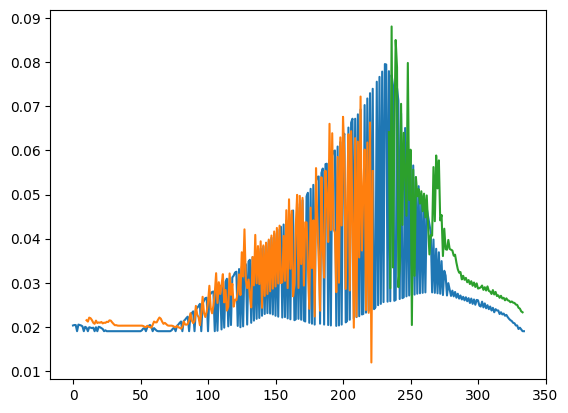

215 107


2023-03-26 21:56:38.716486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:56:38.971708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 21:56:39.118430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/7 [===>..........................] - ETA: 3s

2023-03-26 22:01:18.610145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 22:01:18.695617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step
Train Score: 0.0062 RMSE
Test Score: 0.0172 RMSE


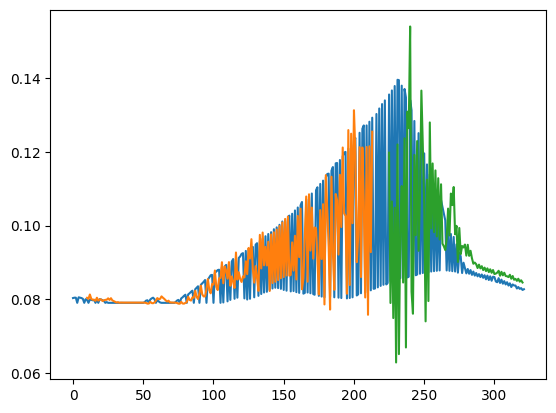

In [60]:
train_predict_plot(df_linux_unix, 'LSTM')
train_predict_plot(df_red_hat, 'LSTM')
train_predict_plot(df_suse_linux, 'LSTM')

215 107


2023-03-26 22:06:09.780419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 22:06:10.027755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 22:06:10.299919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 22:11:39.893259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 22:11:40.038166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 4ms/step
Train Score: 0.0061 RMSE
Test Score: 0.0165 RMSE


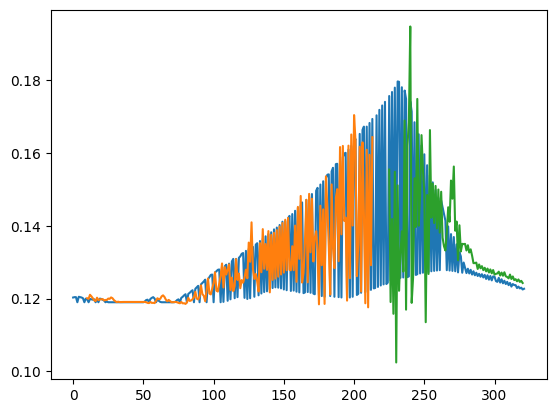

In [62]:
train_predict_plot(df_linux_unix, 'MLP')
train_predict_plot(df_red_hat, 'MLP')
train_predict_plot(df_suse_linux, 'MLP')